In [2]:
# test GPU

import tensorflow as tf
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

print tf.__version__
# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

[[22. 28.]
 [49. 64.]]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10413991498869867075
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 278855680
locality {
  bus_id: 1
}
incarnation: 14206275939698194035
physical_device_desc: "device: 0, name: TITAN X (Pascal), pci bus id: 0000:03:00.0, compute capability: 6.1"
]
1.6.0


## Small U-Net for vehicle detection

#### Vivek Yadav, PhD


### Overview

In this repository , we will go over using U-net for detecting vehicles in a video stream of images provided by Udacity. U-net is a encoder-decoder type of network for pixel-wise predictions. U-net is unique because in U-net, the receptive fields after convolution are concatenated with the receptive fields in up-convolving process. This additional feature allows network to use original features in addition to features after up-convolution. This results in overall better performance than a network that has access to only features after up-convolution. Post-training, the network was correctly able to identify vehicles in an urban setting, and more interestingly performed better than humans in cases where cars were not correctly annotated.

We will go over data processing steps, augmentation technique and training details to explain how we trained U-net to detect vehicles in Urban Setting. This solution was inspired by the original research paper on [U-net](http://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) and the prize winning submission to kaggle’s ultrasound segmentation challenge. All the training was done on my [Titan X computer](https://medium.com/@vivek.yadav/deep-learning-machine-first-build-experience-d04abf198831#.vce02edyb).

### The Data

We used annotated vehicle data set provided by [Udacity](https://www.udacity.com/). The [4.5 GB data set](https://github.com/udacity/self-driving-car/tree/master/annotation) was composed of frames collected from two of videos while driving the Udacity car around Mountain View area in heavy traffic. The data set contained a label file with bounding boxes marking other cars, trucks and pedestrians. The entire data set was comprised of about 22000 images. We combined cars and trucks into one class vehicle, and dropped all the bounding boxes for pedestrians. Mainly because the number of cars far exceeded the number of trucks and pedestrians in the data set.


##### IMPORTANT: The xmin, xmax, ymin and ymax values were marked incorrectly in the Udacity data, so I corrected them. This correction can be found in the code block where data frames are defined. Further, as data from two sources are combined, the column names were modified to match. 


### Data preparation and augmentation

We first divided the data into training and testing data sets. As the frames were obtained from a video feed, each frame was dependent upon the previous frames, we therefore last 2000 images for testing, and remaining images for training. We then performed augmentation on training data set. We performed only 3 augmentation in this project. These were stretching, translation and brightness augmentation. We specifically chose these three transformations to preserve the rectangular shape of the bounding boxes. Another interesting augmentation we considered was to flip the images about the vertical axis randomly, however we decided against it. For those interested, flipping data in Left side drive system (like US) is an easy way to transform data to traffic patterns expected in India or other countries that follow right side drive system.


#### Stretching:

Figure below shows how stretching augmentation works. We first define 4 points near corners of the original image (shown in purple). We then stretch these points so these points become the new boundary points. We modify the bounding boxes accordingly. We did not discard the bounding boxes outside the image, reason for this will be clear in coming images.


<img src='images/StretchAugmentation.png'>


#### Translation:


We next apply translation transformation, to generate the effect of cars being at different locations.

<img src='images/translate.png'>


#### Brightness augmentation

In addition to the stretching and translation augmentation, brightness augmentation was applied to account for different lighting conditions. 

### Target set preparation:

In typical pixel-wise prediction, we draw polygons around the object of interest to draw masks. In this case, we did not have that information, we therefore used the region within the bounding boxes as masks for defining objects. We then used these masks to generate a mask of the same size, which when applied to the original images gives us vehicles back. This is also illustrated in the figure below. The images on the left panel are obtained using augmentation on an naive image, the center panel presents the vehicle mask we intend to predict and the final panel shows the result of applying the mask back on the original image to confirm that the mask in fact identifies vehicles. The goal of our neural network model is to predict the mask in the center, given the image on the left.

<img src='images/TargetSegment.png'>


### Model:
The model we chose is is a scaled down version of a deep learning architecture called U-net. U-net is a encoder-decoder type network architecture for image segmentation. The name of the architecture comes from its unique shape, where the feature maps from convolution part in downsampling step are fed to the up-convolution part in up-sampling step. U-net has been used extensively for biomedical applications to detect cancer, kidney pathologies and tracking cells etc. U-net has proven to be very powerful segmentation tool in scenarios with limited data (less than 50 training samples in some cases). Another advantage of using a U-net is that it does not have any fully connected layers, therefore has no restriction on the size of the input image. This feature allows us to extract features from images of different sizes, which is an attractive attribute for applying deep learning to high fidelity biomedical imaging data. The ability of U-net to work with very little data and no specific requirement on input image size make it a strong candidate for image segmentation tasks.
Another reason to choose the U-net architecture is the letter U. As the data set was provided by Udacity and as am currently enrolled in Udacity’s self-driving car, choice of U-net was a fitting tribute to Udacity.



<img src='images/Unet.png'>


U-net, taken from http://lmb.informatik.uni-freiburg.de/Publications/2015/RFB15a/ (better illustration of U-net coming soon)
The input to U-net is a resized 960X640 3-channel RGB image and output is 960X640 1-channel mask of predictions. We wanted the predictions to reflect probability of a pixel being a vehicle or not, so we used an activation function of sigmoid on the last layer.


### Training:

As with any segmentation deep learning neural network, training took long time. We were unable to fit data set with batch size more than 1 on a titan X gpu with the full U-net, we therefore decided to choose a batch size of 1 for all architectures. This 1 image was randomly samples and augmented from all training images. As we chose a batch size of 1, we chose adam optimizer with a learning rate of 0.0001. Setting up the training itself was straight forward, but training the segmentation model made my Titan X gpu cringe. To perform 10000 iterations, my titan X machine took about 20 minutes.

<img src='images/Training.png'>



### Objective:

We defined a custom objective function in keras to compute approximate Intersection over Union (IoU) between the network output and target mask. IoU is a popular metric of choice for tasks involving bounding boxes. The objective was to maximize IoU, as IoU always varies between 0 and 1, we simply chose to minimize the negative of IoU.



#### Intersection over Union (IoU) metric for bounding boxes

Instead of implementing a direct computation for intersection over union or cross entropy, we used a much simpler metric for area where we multiply two times the network’s output with the target mask, and divide it by the sum of all values in the predicted output and the true mask. This trick helped us avoid computationally involved area calculations, which resulted in lower training times.


<img src='images/IOU.png'>


#### Results:

We stopped the training after 2 hours, and decided to use the network to make predictions. In test time, no augmentation was applied for prediction. The algorithm was surprisingly fast. It took 200ms to make 10 predictions (average of 20ms per image), this included reading file off of disk, and drawing the blobs.

Figures below present performance of the model for vehicle detection. It was surprising that the neural network was able to identify cars correctly in the driving frames it did not see before. Figures below present result of segmentation algorithm applied for vehicle predictions. The panels are organized as original image, predicted mask and ground truth boxes.

<img src='images/Results_Unet.png'>








#### Better than Human performance


Below are a few examples where the intersection over union value was low. However, on further investigation we found that in these cases the car was not marked in the data set and the segmentation model correctly placed a mask on the car location. This strongly suggests that our model learned to identify cars and is not simply replicating the training data.

<img src='images/betterthanHuman1.png'>

<img src='images/betterthanHuman2.png'>

<img src='images/betterthanHuman3.png'>



There were a few bad examples too where the car wrongly identified area that are not cars as cars. However, such examples were few in the test data set.

<img src='images/Bad.png'>


Finally to test how well the model generalizes to unseen data, we ran the U-net algorithm on one of the images from highway driving data provided for the project video. Figure below shows that the model correctly identified the cars, both in its lane and in the opposite lane. What is even more surprising is that the model identified cars that were occluded by the railings on the side. I didnt notice the car until I saw red marks from U-net segmentation myself. The algorithm did identify some additional region as possible car location, but given the fact that it didnt miss any car, we consider this algorithm a successful detection algorithm.


<img src='images/project.png'>


### Applying on video

In a final step, we applied U-net on project video. To remove false positives, we averaged outputs of the Unet from 10 previous frames, and thresholded them at 240 pixel intensity. This method resulted in removal of falst positives, but increased the response time of the network. The videos below present performance on project and challenge videos. 


#### Project videos


[![Algorithm performance on Project Video](https://img.youtube.com/vi/j8pbKhN9e_A/0.jpg)](https://www.youtube.com/watch?v=j8pbKhN9e_A)


[![Algorithm performance on Project Video](https://img.youtube.com/vi/X3nEDhAuZ0s/0.jpg)](https://www.youtube.com/watch?v=X3nEDhAuZ0s)

#### Challenge videos


[![Algorithm performance on Project Video](https://img.youtube.com/vi/k6yuzmH3KNI/0.jpg)](https://www.youtube.com/watch?v=k6yuzmH3KNI)


[![Algorithm performance on Project Video](https://img.youtube.com/vi/1qyAtDLP4rs/0.jpg)](https://www.youtube.com/watch?v=1qyAtDLP4rs)



### Reflections:

This was a very interesting project for many reasons. This was first time I implemented segmentation model on a relatively wild data set. It was the the first time I saw my Titan X computer struggle to run through convnets. Overall, I was extremely happy with the results, and surprised by how well the U-net architecture learned to detect cars. In some cases, it performed better than humans marking the original data set. I was especially surprised when it correctly identified car in the opposite late that I had missed until I saw the red blob over railings. In this case, the network worked better than me, and am proud of it :D One important thing to note is that the model performed well and identified cars in the data set that were not marked as cars too. This suggests that the model’s performance can be further improved if we chose a data set with fewer errors. Next I will incorporate data from KITTI and other sources and test if the model performance improves. Next steps to try are to,
Try other cost functions, especially a true Intersection over Union and cross entropy loss function.
Merge data from multiple sources and check how the model performs on new data.
Use pretrained model for the convolution part of the U-net model, and combine ROI pooling with segmentation to get faster object detection.

### Acknowledgements:
I am very thankful to Udacity for selecting me for the first cohort, this allowed me to connect with many like-minded individuals. I especially learned a lot from discussions with Henrik Tünnermann and John Chen. I am also thankful for getting the NVIDA’s GPU grant. Although, its for work, but I use it for Udacity too. :)




#### Additional links:

1. Good collection of various segmentation models: https://handong1587.github.io/deep_learning/2015/10/09/segmentation.html
2. Original prize winning submission to Kaggle https://github.com/jocicmarko/ultrasound-nerve-segmentation



In [ ]:
### We will next go over the python implementation of U-net

In [3]:
### Import libraries

import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
% matplotlib inline
import glob

from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D,Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from scipy.ndimage.measurements import label
import time


In [4]:
## Get path where files are to be stored

dir_label = ['object-dataset',
            'object-detection-crowdai']

In [5]:
### Make data frame in Pandas

import pandas as pd


df_files1 = pd.read_csv(dir_label[1]+'/labels.csv', header=0)
df_vehicles1 = df_files1[(df_files1['Label']=='Car') | (df_files1['Label']=='Truck')].reset_index()
df_vehicles1 = df_vehicles1.drop('index', 1)
df_vehicles1['File_Path'] =  dir_label[1] + '/' +df_vehicles1['Frame']
df_vehicles1 = df_vehicles1.drop('Preview URL', 1)
print(dir_label[1])
df_vehicles1.head()

object-detection-crowdai


,xmin,xmax,ymin,ymax,Frame,Label,File_Path
0,785,533,905,644,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
1,89,551,291,680,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
2,268,546,383,650,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
3,455,522,548,615,1479498371963069978.jpg,Truck,object-detection-crowdai/1479498371963069978.jpg
4,548,522,625,605,1479498371963069978.jpg,Truck,object-detection-crowdai/1479498371963069978.jpg


In [54]:
### Get data frame from second source
### Renamed columns to correct xmin,xmax,ymin, ymax values. 
### REnamed frames and labels to match crowd-awi source 

df_files2 = pd.read_csv('object-dataset/labels.csv', header=None)
df_files2.columns= ['Frame',  'xmin', 'xmax', 'ymin','ymax', 'ind', 'Label','RM']
df_vehicles2 = df_files2[(df_files2['Label']=='car') | (df_files2['Label']=='truck')].reset_index()
df_vehicles2 = df_vehicles2.drop('index', 1)
df_vehicles2 = df_vehicles2.drop('RM', 1)
df_vehicles2 = df_vehicles2.drop('ind', 1)

df_vehicles2['File_Path'] = dir_label[0] + '/' +df_vehicles2['Frame']

df_vehicles2.head()

ValueError: Length mismatch: Expected axis has 1 elements, new values have 8 elements

In [79]:
### Combine data frames

df_vehicles = pd.concat([df_vehicles1,df_vehicles2]).reset_index()
df_vehicles = df_vehicles.drop('index', 1)
df_vehicles.columns =['File_Path','Frame','Label','ymin','xmin','ymax','xmax']
df_vehicles.head()

NameError: name 'df_vehicles2' is not defined

In [6]:
df_vehicles = df_vehicles1
# df_vehicles.columns =['File_Path','Frame','Label','ymin','xmin','ymax','xmax']
df_vehicles.columns =['xmin','ymin','xmax','ymax','Frame','Label','File_Path']

df_vehicles.head()

,xmin,ymin,xmax,ymax,Frame,Label,File_Path
0,785,533,905,644,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
1,89,551,291,680,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
2,268,546,383,650,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
3,455,522,548,615,1479498371963069978.jpg,Truck,object-detection-crowdai/1479498371963069978.jpg
4,548,522,625,605,1479498371963069978.jpg,Truck,object-detection-crowdai/1479498371963069978.jpg


In [7]:
df_vehicles.tail()

,xmin,ymin,xmax,ymax,Frame,Label,File_Path
66384,958,559,1045,621,1479506176491553178.jpg,Car,object-detection-crowdai/1479506176491553178.jpg
66385,1038,558,1122,630,1479506176491553178.jpg,Car,object-detection-crowdai/1479506176491553178.jpg
66386,667,558,747,626,1479506176491553178.jpg,Car,object-detection-crowdai/1479506176491553178.jpg
66387,730,568,818,613,1479506176491553178.jpg,Car,object-detection-crowdai/1479506176491553178.jpg
66388,435,551,532,589,1479506176491553178.jpg,Car,object-detection-crowdai/1479506176491553178.jpg


In [8]:
trans_range = 0

In [9]:
### Augmentation functions 

def augment_brightness_camera_images(image):
    
    ### Augment brightness 
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def trans_image(image,bb_boxes_f,trans_range):
    # Translation augmentation
    bb_boxes_f = bb_boxes_f.copy(deep=True)

    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2

    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    rows,cols,channels = image.shape
    bb_boxes_f['xmin'] = bb_boxes_f['xmin']+tr_x
    bb_boxes_f['xmax'] = bb_boxes_f['xmax']+tr_x
    bb_boxes_f['ymin'] = bb_boxes_f['ymin']+tr_y
    bb_boxes_f['ymax'] = bb_boxes_f['ymax']+tr_y
    
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,bb_boxes_f


def stretch_image(img,bb_boxes_f,scale_range):
    # Stretching augmentation 
    
    bb_boxes_f = bb_boxes_f.copy(deep=True)
    
    tr_x1 = scale_range*np.random.uniform()
    tr_y1 = scale_range*np.random.uniform()
    p1 = (tr_x1,tr_y1)
    tr_x2 = scale_range*np.random.uniform()
    tr_y2 = scale_range*np.random.uniform()
    p2 = (img.shape[1]-tr_x2,tr_y1)

    p3 = (img.shape[1]-tr_x2,img.shape[0]-tr_y2)
    p4 = (tr_x1,img.shape[0]-tr_y2)

    pts1 = np.float32([[p1[0],p1[1]],
                   [p2[0],p2[1]],
                   [p3[0],p3[1]],
                   [p4[0],p4[1]]])
    pts2 = np.float32([[0,0],
                   [img.shape[1],0],
                   [img.shape[1],img.shape[0]],
                   [0,img.shape[0]] ]
                   )

    M = cv2.getPerspectiveTransform(pts1,pts2)
    img = cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]))
    img = np.array(img,dtype=np.uint8)
    
    bb_boxes_f['xmin'] = (bb_boxes_f['xmin'] - p1[0])/(p2[0]-p1[0])*img.shape[1]
    bb_boxes_f['xmax'] = (bb_boxes_f['xmax'] - p1[0])/(p2[0]-p1[0])*img.shape[1]
    bb_boxes_f['ymin'] = (bb_boxes_f['ymin'] - p1[1])/(p3[1]-p1[1])*img.shape[0]
    bb_boxes_f['ymax'] = (bb_boxes_f['ymax'] - p1[1])/(p3[1]-p1[1])*img.shape[0]
    
    return img,bb_boxes_f



def get_image_name(df,ind,size=(640,300),augmentation = False,trans_range = 20,scale_range=20):
    ### Get image by name
    
    file_name = df['File_Path'][ind]
    img = cv2.imread(file_name)
    img_size = np.shape(img)
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,size)
    name_str = file_name.split('/')
    name_str = name_str[-1]
    #print(name_str)
    #print(file_name)
    bb_boxes = df[df['Frame'] == name_str].reset_index()
    img_size_post = np.shape(img)
    
    if augmentation == True:
        img,bb_boxes = trans_image(img,bb_boxes,trans_range)
        img,bb_boxes = stretch_image(img,bb_boxes,scale_range)
        img = augment_brightness_camera_images(img)
#     print bb_boxes    
    bb_boxes['xmin'] = np.round(bb_boxes['xmin']/img_size[1]*img_size_post[1])
    bb_boxes['xmax'] = np.round(bb_boxes['xmax']/img_size[1]*img_size_post[1])
    bb_boxes['ymin'] = np.round(bb_boxes['ymin']/img_size[0]*img_size_post[0])
    bb_boxes['ymax'] = np.round(bb_boxes['ymax']/img_size[0]*img_size_post[0])
    bb_boxes['Area'] = (bb_boxes['xmax']- bb_boxes['xmin'])*(bb_boxes['ymax']- bb_boxes['ymin']) 
    #bb_boxes = bb_boxes[bb_boxes['Area']>400]
#     print bb_boxes
        
    
    return name_str,img,bb_boxes


def get_mask_seg(img,bb_boxes_f):
    
    #### Get mask 
    
    img_mask = np.zeros_like(img[:,:,0])
    for i in range(len(bb_boxes_f)):
        #plot_bbox(bb_boxes,i,'g')
#         bb_box_i = [bb_boxes_f.iloc[i]['xmin'],bb_boxes_f.iloc[i]['ymin'],
#                 bb_boxes_f.iloc[i]['xmax'],bb_boxes_f.iloc[i]['ymax']]
        bb_box_i = [int(bb_boxes_f.iloc[i]['xmin']),int(bb_boxes_f.iloc[i]['ymin']),
                int(bb_boxes_f.iloc[i]['xmax']),int(bb_boxes_f.iloc[i]['ymax'])]
        img_mask[bb_box_i[1]:bb_box_i[3],bb_box_i[0]:bb_box_i[2]]= 1.
        img_mask = np.reshape(img_mask,(np.shape(img_mask)[0],np.shape(img_mask)[1],1))
    return img_mask

In [10]:
def plot_im_mask(im,im_mask):
    ### Function to plot image mask 
    
    im = np.array(im,dtype=np.uint8)
    im_mask = np.array(im_mask,dtype=np.uint8)
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(im_mask[:,:,0])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(cv2.bitwise_and(im,im,mask=im_mask));
    plt.axis('off')
    plt.show();
    
def plot_bbox(bb_boxes,ind_bb,color='r',linewidth=2):
    ### Plot bounding box
    
    bb_box_i = [bb_boxes.iloc[ind_bb]['xmin'],
                bb_boxes.iloc[ind_bb]['ymin'],
                bb_boxes.iloc[ind_bb]['xmax'],
                bb_boxes.iloc[ind_bb]['ymax']]
    plt.plot([bb_box_i[0],bb_box_i[2],bb_box_i[2],
                  bb_box_i[0],bb_box_i[0]],
             [bb_box_i[1],bb_box_i[1],bb_box_i[3],
                  bb_box_i[3],bb_box_i[1]],
             color,linewidth=linewidth)
    
def plot_im_bbox(im,bb_boxes):
    ### Plot image and bounding box
    plt.imshow(im)
    for i in range(len(bb_boxes)):
        plot_bbox(bb_boxes,i,'g')
    
        bb_box_i = [bb_boxes.iloc[i]['xmin'],bb_boxes.iloc[i]['ymin'],
                bb_boxes.iloc[i]['xmax'],bb_boxes.iloc[i]['ymax']]
        plt.plot(bb_box_i[0],bb_box_i[1],'rs')
        plt.plot(bb_box_i[2],bb_box_i[3],'bs')
    plt.axis('off');


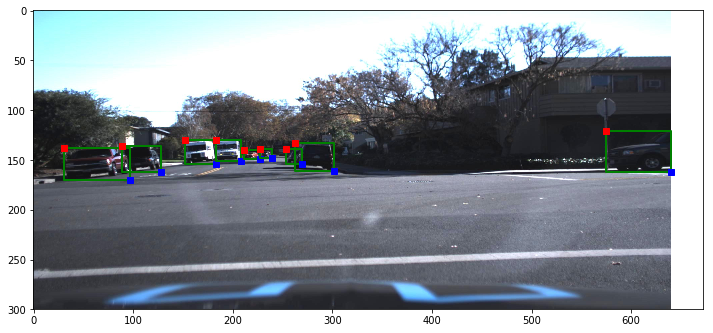

In [11]:
## test
name_str,img,bb_boxes = get_image_name(df_vehicles,1,augmentation=False,trans_range=0,scale_range=0)
plt.figure(figsize=(12,8))
plt.imshow(img)
for i in range(len(bb_boxes)):
    plot_bbox(bb_boxes,i,'g')
    bb_box_i = [bb_boxes.iloc[i]['xmin'],bb_boxes.iloc[i]['ymin'],
                bb_boxes.iloc[i]['xmax'],bb_boxes.iloc[i]['ymax']]
    plt.plot(bb_box_i[0],bb_box_i[1],'rs')
    plt.plot(bb_box_i[2],bb_box_i[3],'bs')

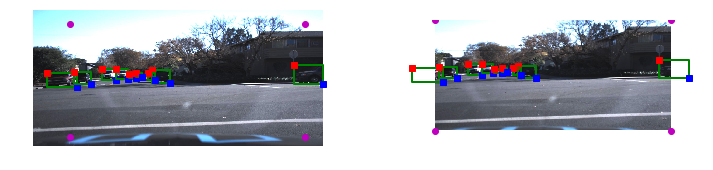

In [12]:
#### Test translation and stretching augmentations

name_str,img,bb_boxes = get_image_name(df_vehicles,1,augmentation=False,trans_range=0,scale_range=0)
img_mask =get_mask_seg(img,bb_boxes)

tr_x1 = 80
tr_y1 = 30
tr_x2 = 40
tr_y2 = 20



p1 = (tr_x1,tr_y1)
p2 = (img.shape[1]-tr_x2,tr_y1)

p3 = (img.shape[1]-tr_x2,img.shape[0]-tr_y2)
p4 = (tr_x1,img.shape[0]-tr_y2)

pts1 = np.float32([[p1[0],p1[1]],
                   [p2[0],p2[1]],
                   [p3[0],p3[1]],
                   [p4[0],p4[1]]])
pts2 = np.float32([[0,0],
                   [img.shape[1],0],
                   [img.shape[1],img.shape[0]],[0,img.shape[0]] ]
                   )

M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]))
dst = np.array(dst,dtype=np.uint8)


plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.plot(p1[0],p1[1],'mo')
plt.plot(p2[0],p2[1],'mo')
plt.plot(p3[0],p3[1],'mo')
plt.plot(p4[0],p4[1],'mo')
for i in range(len(bb_boxes)):
    plot_bbox(bb_boxes,i,'g')
    
    bb_box_i = [bb_boxes.iloc[i]['xmin'],bb_boxes.iloc[i]['ymin'],
                bb_boxes.iloc[i]['xmax'],bb_boxes.iloc[i]['ymax']]
    plt.plot(bb_box_i[0],bb_box_i[1],'rs')
    plt.plot(bb_box_i[2],bb_box_i[3],'bs')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(dst)
bb_boxes1 = bb_boxes.copy(deep=True)
bb_boxes1['xmin'] = (bb_boxes['xmin'] - p1[0])/(p2[0]-p1[0])*img.shape[1]
bb_boxes1['xmax'] = (bb_boxes['xmax'] - p1[0])/(p2[0]-p1[0])*img.shape[1]
bb_boxes1['ymin'] = (bb_boxes['ymin'] - p1[1])/(p3[1]-p1[1])*img.shape[0]
bb_boxes1['ymax'] = (bb_boxes['ymax'] - p1[1])/(p3[1]-p1[1])*img.shape[0]
plt.plot(0,0,'mo')
plt.plot(img.shape[1],0,'mo')
plt.plot(img.shape[1],img.shape[0],'mo')
plt.plot(0,img.shape[0],'mo')
plot_im_bbox(dst,bb_boxes1)

plt.axis('off');


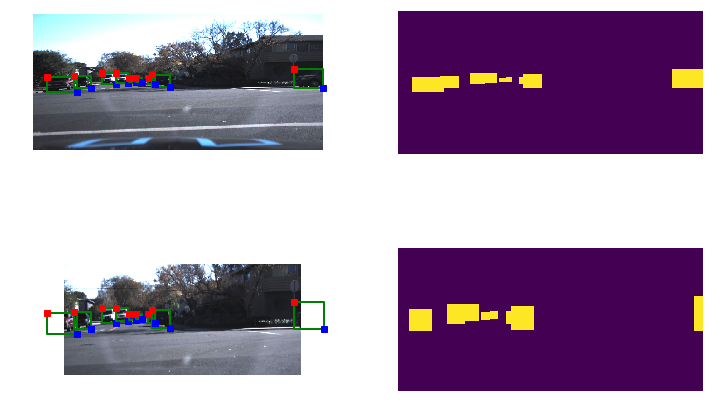

In [13]:
#### Test translation and stretching augmentations

name_str,img,bb_boxes = get_image_name(df_vehicles,1,augmentation=False)
img_mask =get_mask_seg(img,bb_boxes)

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plot_im_bbox(img,bb_boxes)

plt.subplot(2,2,2)
plt.imshow(img_mask[:,:,0])
plt.axis('off')

plt.subplot(2,2,3)
#bb_boxes1 = bb_boxes.copy()
dst,bb_boxes1 = stretch_image(img,bb_boxes,100)

plt.imshow(dst)

plot_im_bbox(dst,bb_boxes1)

plt.subplot(2,2,4)
img_mask2 =get_mask_seg(dst,bb_boxes1)
plt.imshow(img_mask2[:,:,0])
plt.axis('off');

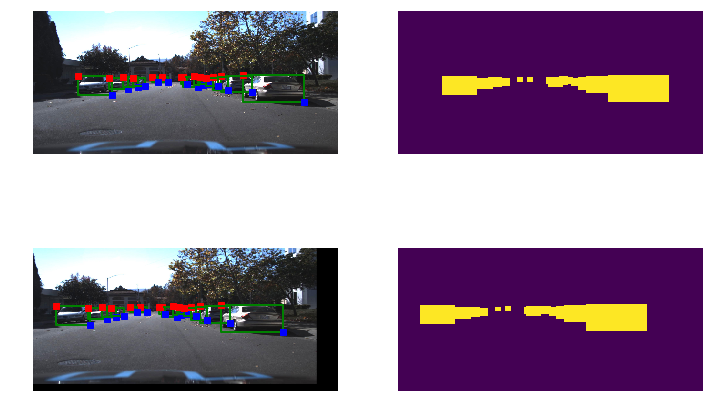

In [14]:
#### Test translation and stretching augmentations

name_str,img,bb_boxes = get_image_name(df_vehicles,200,augmentation=False)
img_mask =get_mask_seg(img,bb_boxes)

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plot_im_bbox(img,bb_boxes)

plt.subplot(2,2,2)
plt.imshow(img_mask[:,:,0])
plt.axis('off')

plt.subplot(2,2,3)
#bb_boxes1 = bb_boxes.copy()
img_trans,bb_boxes1 = trans_image(img,bb_boxes,100)

plt.imshow(img_trans)

plot_im_bbox(img_trans,bb_boxes1)
img_mask2 =get_mask_seg(img_trans,bb_boxes1)

plt.subplot(2,2,4)
plt.imshow(img_mask2[:,:,0])
plt.axis('off');

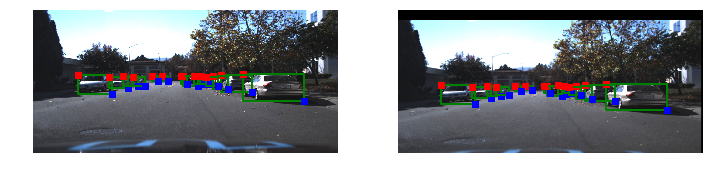

In [15]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plot_im_bbox(img,bb_boxes)
plt.subplot(2,2,2)
#bb_boxes1 = bb_boxes.copy()
img_trans,bb_boxes1 = trans_image(img,bb_boxes,50)
plt.imshow(img_trans)
plot_im_bbox(img_trans,bb_boxes1)


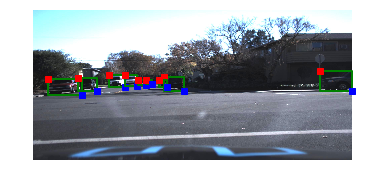

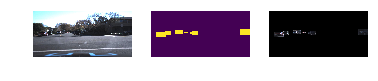

In [16]:
#### Put all the augmentations in 1 function with a flag for augmentation


name_str,img,bb_boxes = get_image_name(df_vehicles,1,augmentation=False)
img_mask =get_mask_seg(img,bb_boxes)


plt.figure(figsize=(6,4))
plt.imshow(img)
plot_im_bbox(img,bb_boxes)
plt.show()

plot_im_mask(img,img_mask)

In [17]:
#### Training generator, generates augmented images
def generate_train_batch(data,batch_size = 32):
    
    batch_images = np.zeros((batch_size, img_rows, img_cols, 3))
    batch_masks = np.zeros((batch_size, img_rows, img_cols, 1))
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data)-2000)
            name_str,img,bb_boxes = get_image_name(df_vehicles,i_line,
                                                   size=(img_cols, img_rows),
                                                  augmentation=True,
                                                   trans_range=50,
                                                   scale_range=50
                                                  )
            img_mask = get_mask_seg(img,bb_boxes)
            batch_images[i_batch] = img
            batch_masks[i_batch] =img_mask
        yield batch_images, batch_masks
        
#### Testing generator, generates augmented images
def generate_test_batch(data,batch_size = 32):
    batch_images = np.zeros((batch_size, img_rows, img_cols, 3))
    batch_masks = np.zeros((batch_size, img_rows, img_cols, 1))
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(2000)
            i_line = i_line+len(data)-2000
            name_str,img,bb_boxes = get_image_name(df_vehicles,i_line,
                                                   size=(img_cols, img_rows),
                                                  augmentation=False,
                                                   trans_range=0,
                                                   scale_range=0
                                                  )
            img_mask = get_mask_seg(img,bb_boxes)
            batch_images[i_batch] = img
            batch_masks[i_batch] =img_mask
        yield batch_images, batch_masks

In [18]:
##### Image size, 
img_rows = 640
img_cols = 960

In [63]:
##### Testing the generator


training_gen = generate_train_batch(df_vehicles,10)

In [70]:
## test generator example
def createGenerator():
    mylist = range(3)
    for i in mylist:
        yield i*i

mygenerator = createGenerator() # create a generator
# print(mygenerator) # mygenerator is an object!
text = next(mygenerator)
for xx in range(3):
    print text
    text

# for i in mygenerator:
#     print(i)
# for i in mygenerator:
#     print(i)

0
0
0


In [76]:
batch_img,batch_mask = next(training_gen)


0


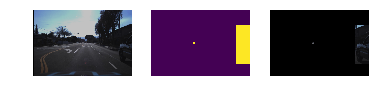

1


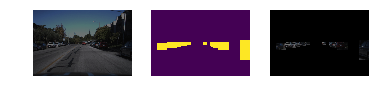

2


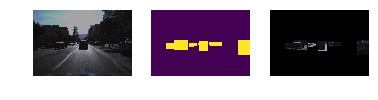

3


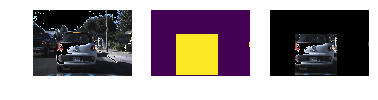

4


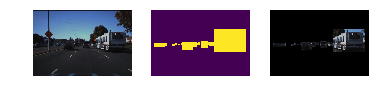

5


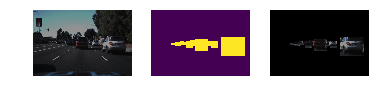

6


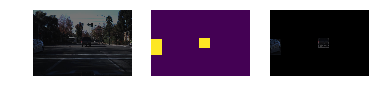

7


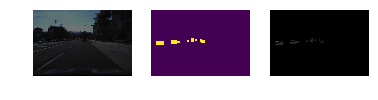

8


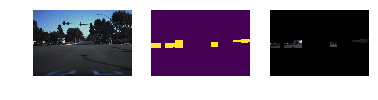

9


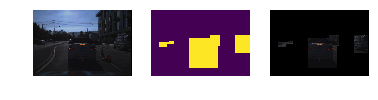

In [78]:
### Plotting generator output
for i in range(10):
    print i
    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(batch_mask[i],dtype=np.uint8)
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(im_mask[:,:,0])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(cv2.bitwise_and(im,im,mask=im_mask));
    plt.axis('off')
    plt.show();

In [22]:
len(df_vehicles)

66389

In [23]:
### IOU or dice coeff calculation

def IOU_calc(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def IOU_calc_loss(y_true, y_pred):
    return -IOU_calc(y_true, y_pred)

In [24]:
### Defining a small Unet
### Smaller Unet defined so it fits in memory

def get_small_unet():
    inputs = Input((img_rows, img_cols,3))
    inputs_norm = Lambda(lambda x: x/127.5 - 1.)
    conv1 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=3)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=3)
    conv7 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=3)
    conv8 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=3)
    conv9 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    
    return model

In [90]:
### Generator 

training_gen = generate_train_batch(df_vehicles,1)
smooth = 1.
model = get_small_unet()
model.compile(optimizer=Adam(lr=1e-4), 
              loss=IOU_calc_loss, metrics=[IOU_calc])

/home/cyeh/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), padding="same", activation="relu")`
  import sys
/home/cyeh/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), padding="same", activation="relu")`
  
/home/cyeh/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/home/cyeh/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", activation="relu")`
  if sys.path[0] == '':
/home/cyeh/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3

In [26]:
#model.summary()

In [27]:
### Using previously trained data. Set load_pretrained = False, increase epochs and train for full training.
load_pretrained = True
if load_pretrained == True:
    model.load_weights("model_segn_small_0p72.h5")        

In [28]:
history = model.fit_generator(training_gen,
            samples_per_epoch=1000, 
                              nb_epoch=1)

/home/cyeh/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cyeh/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=1, steps_per_epoch=1000)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/1
1000/1000 [==============================] - 63s 63ms/step - loss: -0.6855 - IOU_calc: 0.6855 0s - loss: -0.6847 - IOU_calc: 0


In [29]:
### Save model for use in detection pipeline

model.save('model_detect_SmallUnet.h5')

In [32]:
!which python

/home/cyeh/anaconda/bin/python


In [35]:
### Plot model using Keras 

from IPython.display import SVG
# from keras.utils.visualize_util import model_to_dot
# from keras.utils.visualize_util import plot
from keras.utils.vis_util import model_to_dot
from keras.utils.vis_util import plot

plot(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

ImportError: No module named vis_util

In [36]:
### Save weights 
model.save_weights("model_segn_small_udacity_0p71.h5", overwrite=True)

In [149]:
### Testing generator

testing_gen = generate_test_batch(df_vehicles,20)
# testing_gen = generate_test_batch(df_vehicles,100)


In [150]:
np.shape(im)

(640, 960, 3)

In [156]:
import time
batch_img,batch_mask = next(testing_gen)
start = time.time()

pred_all= model.predict(batch_img)
end = time.time()
end-start

0.6268079280853271

0


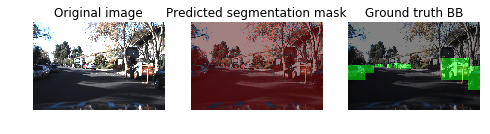

1


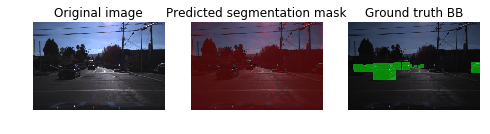

2


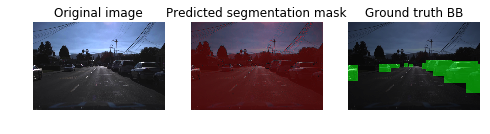

3


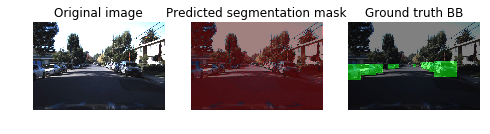

4


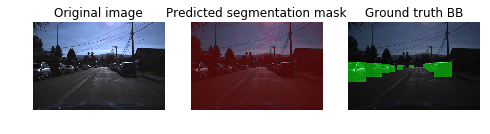

5


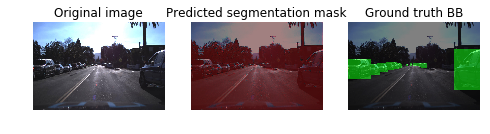

6


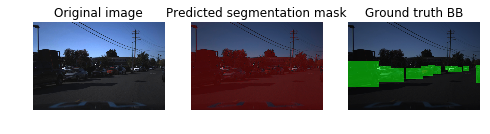

7


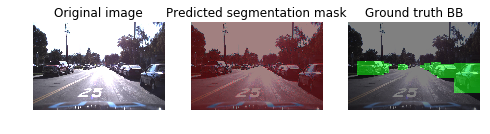

8


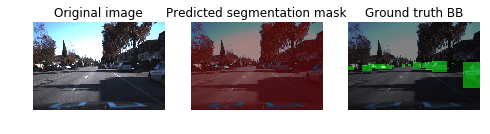

9


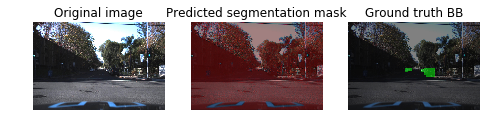

10


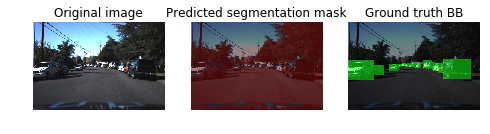

11


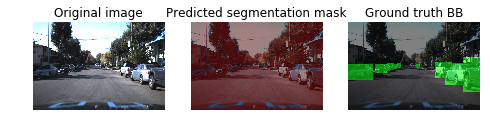

12


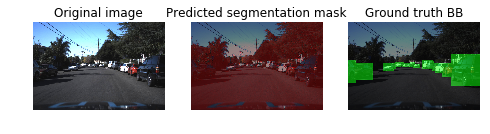

13


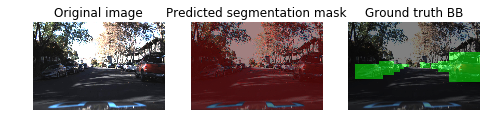

14


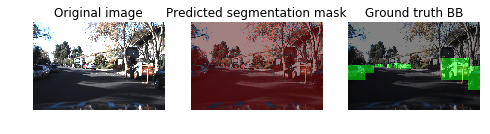

15


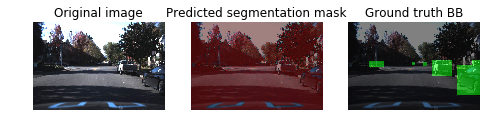

16


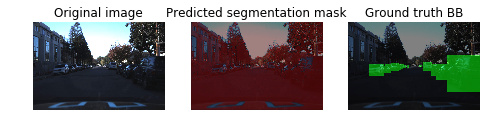

17


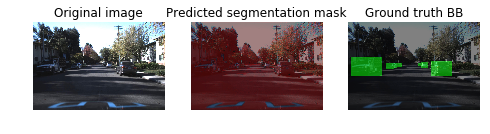

18


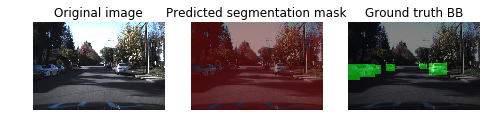

19


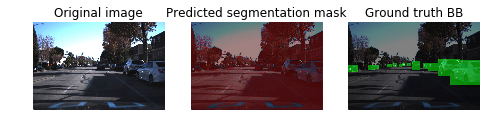

In [157]:
### Test on last frames of data

batch_img,batch_mask = next(testing_gen)
pred_all= model.predict(batch_img)
np.shape(pred_all)

for i in range(20):
    print i
    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(255*batch_mask[i],dtype=np.uint8)
    im_pred = np.array(255*pred_all[i],dtype=np.uint8)
    
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
    rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
    rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]
    
    img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
    img_true = cv2.addWeighted(rgb_mask_true,0.5,im,0.5,0)
    
    plt.figure(figsize=(8,3))
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img_pred)
    plt.title('Predicted segmentation mask')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(img_true)
    plt.title('Ground truth BB')
    plt.axis('off')
    plt.show()


In [41]:
#### Function for drawing bounding boxes, taken from Ryan's code on Udacity

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        if ((np.max(nonzeroy)-np.min(nonzeroy)>50) & (np.max(nonzerox)-np.min(nonzerox)>50)):
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image       
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255),6)
    # Return the image
    return img

def test_new_img(img):
    img = cv2.resize(img,(img_cols, img_rows))
    img = np.reshape(img,(1,img_rows, img_cols,3))
    pred = model.predict(img)
    return pred,img[0]

def get_BB_new_img(img):
    # Take in RGB image
    pred,img = test_new_img(img)
    img  = np.array(img,dtype= np.uint8)
    img_pred = np.array(255*pred[0],dtype=np.uint8)
    heatmap = im_pred[:,:,0]
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [45]:
### Test on new image

test_img = 'test_images/0003_000470_l.png'
im = cv2.imread(test_img)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)

draw_img = get_BB_new_img(im)


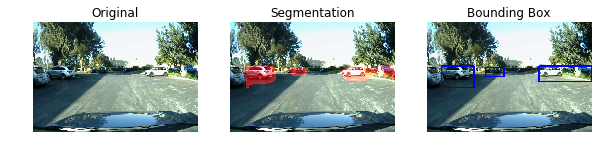

In [53]:
test_img = 'test_images/0003_000470_l.png'
test_img = 'test_images/test2.jpg'
test_img = 'test_images/img_00001.png'

im = cv2.imread(test_img)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
pred,im = test_new_img(im)
im  = np.array(im,dtype= np.uint8)
im_pred = np.array(255*pred[0],dtype=np.uint8)
rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]



img_pred = cv2.addWeighted(rgb_mask_pred,0.55,im,1,0)



#heatmap = im_pred[:,:,0]

#labels = label(heatmap)
# Draw bounding boxes on a copy of the image
#draw_img = draw_labeled_bboxes(np.copy(im), labels)
# Display the image
#img_pred = im
#im_pred[:,:,]

draw_img = get_BB_new_img(im)

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(im)
plt.title('Original')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(img_pred)
plt.title('Segmentation')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(draw_img)
plt.title('Bounding Box')
plt.axis('off');



# diff = end_time - start_time
# diff

In [ ]:
#### EXTRA STUFF THAT I DIDNT USE. 

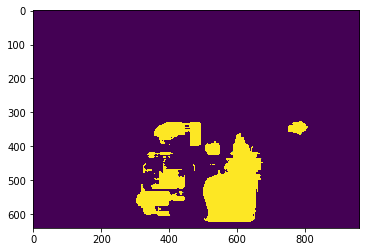

In [47]:
plt.imshow(im_pred[:,:,0])



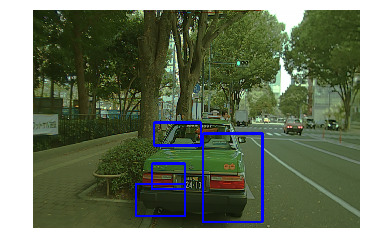

In [48]:

heatmap = im_pred[:,:,0]

labels = label(heatmap)
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(im), labels)
# Display the image
plt.imshow(draw_img)
plt.axis('off');

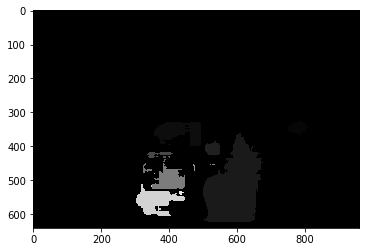

In [49]:
plt.imshow(labels[0],cmap='gray')

In [64]:
np.unique(labels[0])

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [50]:
car_label = 1

blob_non0 = (car_label == labels[0])

img_0 = np.copy(heatmap)*0
img_0[blob_non0] = 255

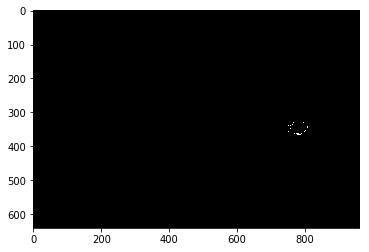

In [51]:
plt.imshow(blob_non0)
img_cny = cv2.Canny(img_0,128,255)
plt.imshow(img_cny,cmap='gray')